In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import numpy.ma as ma
from datetime import datetime
import matplotlib.pyplot as plt
pd.set_option('max_columns', 20)
pd.set_option('max_rows', 25)

import pdb

from __future__ import division

In [2]:
data_dir = "data/"

Import outbreak data

In [3]:
measles_data = pd.read_csv(data_dir+"measles.csv", index_col=0)
measles_data.NOTIFICATION = pd.to_datetime(measles_data.NOTIFICATION)
measles_data.BIRTH = pd.to_datetime(measles_data.BIRTH)
measles_data.ONSET = pd.to_datetime(measles_data.ONSET)

In [4]:
measles_data = measles_data.replace({'DISTRICT': {'BRASILANDIA':'BRAZILANDIA'}})

Sao Paulo population by district

In [5]:
sp_pop = pd.read_csv(data_dir+'sp_pop.csv', index_col=0)

In [6]:
_names = sp_pop.index.values
_names[_names=='BRASILANDIA'] = 'BRAZILANDIA'
sp_pop.set_index(_names, inplace = True)

In [7]:
sp_pop.head()

,0 a 4 anos,5 a 9 anos,10 a 14 anos,15 a 19 anos,20 a 24 anos,25 a 29 anos,30 a 34 anos,35 a 39 anos,40 a 44 anos,45 a 49 anos,50 a 54 anos,55 a 59 anos,60 a 64 anos,65 a 69 anos,70 a 74 anos,75 anos e +,Total
AGUA RASA,5411,5750,6450,7122,7621,7340,6999,6984,6346,5608,4987,4212,4152,3595,2937,3637,89151
ALTO DE PINHEIROS,2070,2369,2953,3661,4612,4190,3539,3633,3448,3289,3040,2533,2298,1732,1305,1823,46495
ANHANGUERA,3068,3006,2755,2431,2426,2636,2695,2308,1653,1107,753,509,352,217,162,171,26249
ARICANDUVA,7732,7730,8373,8956,9182,8531,7813,7365,6551,5554,4887,3858,3320,2449,1611,1723,95635
ARTUR ALVIM,9031,9078,10000,11058,11387,10347,9125,8658,7830,7055,5919,4612,3756,2633,1727,1724,113940


Plot of cumulative cases by district

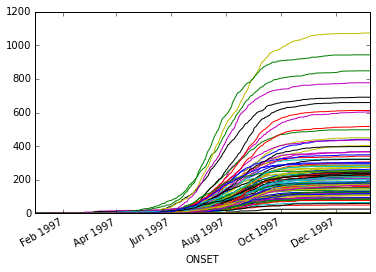

In [8]:
measles_onset_dist = measles_data.groupby(['DISTRICT','ONSET']).size().unstack(level=0).fillna(0)
measles_onset_dist.cumsum().plot(legend=False, grid=False)

Top 5 districts by number of cases

In [9]:
totals = measles_onset_dist.sum()
totals.sort(ascending=False)
totals[:5]

DISTRICT
GRAJAU             1074
JARDIM ANGELA       944
CAPAO REDONDO       849
JARDIM SAO LUIZ     778
CAMPO LIMPO         692
dtype: float64

## Chain Binomial Transmission Model

As a baseline for comparison, we can fit a model to all the clinically-confirmed cases, regardless of lab confirmation status. For this, we will use a simple chain binomial model, which will be fit using MCMC.

This model fits the series of 2-week infection totals as a set of Binomial models:

\\[Pr(I_{t+1} | S_t, p_t) = \text{Bin}(S_t, p_t) \\]

Where the binomial probability is modeled as:

\\[p_t = 1 - \exp\(-\lambda_t\)\\]

\\[\lambda_t = \frac{B_t I_t}{N}\\]

\\[B_j = B_0\\]

which allows the effective reproductive number to be calculated as:

\\[R_t = \frac{\beta S_t}{N}\\]

### Confirmation Sub-model

Rather than assume all clinical cases are true cases, we can adjust the model to account for lab confirmation probability. This is done by including a sub-model that estimates age group-specific probabilities of confirmation, and using these probabilities to estimate the number of lab-confirmed cases. Theses estimaes are then plugged into the model in place of the clinically-confirmed cases.

Age classes are defined in 5-year intervals.

In [10]:
age_classes = [0,5,10,15,20,25,30,35,40,45,50,55,60,66,70,75,100]
measles_data.dropna(subset=['AGE'], inplace=True)
measles_data['AGE_GROUP'] = pd.cut(measles_data.AGE, age_classes, right=False)

Lab-checked observations are extracted for use in estimating lab confirmation probability.

In [11]:
CONFIRMED = measles_data.CONCLUSION == 'CONFIRMED'
CLINICAL = measles_data.CONCLUSION == 'CLINICAL'
DISCARDED = measles_data.CONCLUSION == 'DISCARDED'

In [12]:
lab_subset = measles_data[(CONFIRMED | DISCARDED) & measles_data.YEAR_AGE.notnull() & measles_data.COUNTY.notnull()].copy()
lab_subset.loc[lab_subset.YEAR_AGE > 75, 'YEAR_AGE'] = 75
age = lab_subset.YEAR_AGE.astype(int).values
ages = lab_subset.YEAR_AGE.astype(int).unique()
counties = lab_subset.COUNTY.unique()
y = (lab_subset.CONCLUSION=='CONFIRMED').values

Extract cases by age and time.

In [13]:
age_group = pd.cut(age, age_classes, right=False)
age_index = np.array([age_group.levels.tolist().index(i) for i in age_group])

In [14]:
# Get index from full crosstabulation to use as index for each district
dates_index = measles_data.groupby(
        ['ONSET', 'AGE_GROUP']).size().unstack().index

In [15]:
unique_districts = measles_data.DISTRICT.dropna().unique()

In [16]:
N = sp_pop.ix[unique_districts, 'Total'].dropna()

In [17]:
sp_districts = N.index.values
len(sp_districts)

93

In [18]:
all_district_data = []
all_confirmed_cases = []
for d in sp_districts:
    
    # All bi-weekly unconfirmed and confirmed cases
    district_data = measles_data[measles_data.DISTRICT==d]
    district_counts_2w = district_data.groupby(
        ['ONSET', 'AGE_GROUP']).size().unstack().reindex(dates_index).fillna(0).resample('2W', how='sum')
    all_district_data.append(district_counts_2w)
    
    # All confirmed cases, by district
    confirmed_data = district_data[district_data.CONCLUSION!='CONFIRMED']
    confirmed_counts = confirmed_data.groupby(
        ['ONSET', 'AGE_GROUP']).size().unstack().reindex(dates_index).fillna(0).sum()
    all_confirmed_cases.append(confirmed_counts.reindex_axis(measles_data['AGE_GROUP'].unique()).fillna(0))

Time series of cases by district, summarized in 2-week intervals

In [19]:
# Sum over ages for susceptibles
sp_cases_2w = [dist.sum(1) for dist in all_district_data]

In [20]:
# Ensure the age groups are ordered
I_obs = np.array([dist.reindex_axis(measles_data['AGE_GROUP'].unique(), 
                            axis=1).fillna(0).values.astype(int) for dist in all_district_data])

In [21]:
measles_data['AGE_GROUP'].unique()

array(['[20, 25)', '[5, 10)', '[25, 30)', '[0, 5)', '[35, 40)', '[30, 35)',
       '[50, 55)', '[15, 20)', '[10, 15)', '[40, 45)', '[45, 50)',
       '[75, 100)', '[66, 70)', '[55, 60)', '[70, 75)', '[60, 66)'], dtype=object)

Check shape of data frame

In [22]:
assert I_obs.shape == (93, 28, 16)

### Spatial distance between districts

In [23]:
from shapely.geometry import Point, mapping, shape, MultiPolygon
from fiona import collection
import fiona

shp = fiona.open("Sao Paulo/Brazil_full/BRA_adm3.shp")

In [24]:
import geopandas as gpd

shp = gpd.GeoDataFrame.from_file("Sao Paulo/Brazil_full/BRA_adm3.shp")

In [25]:
district_names = N.index.unique()

In [27]:
import trans
shp['district_name'] = shp.NAME_3.apply(
    lambda x: trans.trans(x).upper())

In [29]:
sp_shp = shp[shp.NAME_2=='São Paulo'].set_index('district_name')

In [30]:
sp_shp.ix['CAMPO LIMPO']

ENGTYPE_3                                              District
HASC_3                                                     None
ID_0                                                         32
ID_1                                                        454
ID_2                                                       8816
ID_3                                                      13779
ISO                                                         BRA
NAME_0                                                   Brazil
NAME_1                                                São Paulo
NAME_2                                                São Paulo
NAME_3                                              Campo Limpo
NL_NAME_3                                                  None
REMARKS_3                                                  None
Shape_Area                                          0.001116783
Shape_Leng                                            0.1537662
TYPE_3                                  

In [31]:
centroids = sp_shp.geometry.centroid

In [32]:
distance_matrix = pd.concat([sp_shp.geometry.distance(o) for o in sp_shp.geometry],
                     axis=1)
distance_matrix.columns = sp_shp.index

In [33]:
min_x, min_y = sp_shp.bounds.min()[:2]
max_x, max_y = sp_shp.bounds.max()[2:]

In [34]:
assert (distance_matrix.index == centroids.index).all()

In [35]:
centroid_xy = np.array([[c.x, c.y] for c in sp_shp.geometry.centroid])

In [36]:
_beta = -100
np.exp(_beta*distance_matrix).values.round(2)[0]

array([ 1.  ,  0.  ,  0.  ,  0.01,  0.  ,  0.12,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.04,  0.  ,  0.  ,  0.  ,
        1.  ,  0.  ,  0.  ,  0.  ,  0.01,  0.01,  0.  ,  0.  ,  0.  ,
        0.01,  0.  ,  0.  ,  0.  ,  0.  ,  0.18,  0.  ,  0.  ,  0.  ,
        0.  ,  0.04,  1.  ,  0.  ,  0.  ,  0.  ,  0.1 ,  0.01,  0.  ,
        0.  ,  0.19,  0.  ,  0.  ,  0.  ,  0.  ,  0.04,  0.  ,  1.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.11,  0.  ,  1.  ,
        0.02,  0.  ,  1.  ,  0.  ,  1.  ,  0.  ,  0.01,  0.  ,  0.02,
        0.03,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.1 ,  0.  ,  0.  ,  0.  ,  0.  ,  0.65,
        0.  ,  0.01,  0.  ,  0.  ,  0.  ,  1.  ])

### Spatial decision model

We attempt to estimate $R_t$ for a truncated subset of the data, to simulate a decision-maker's information during (rather than after) an outbreak. This essentially involves turning part of the time series into missing data, and running the model.

This is an example of creating a mask for data not observed by the decision date.

In [37]:
np.array([np.resize(all_district_data[0].index > '1997-06-15', I_obs[0].T.shape).T]*len(all_district_data))

array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ..., 
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ..., 
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ..., 
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True, 

In [38]:
from pymc import MCMC, Matplot
from pymc import (Uniform, DiscreteUniform, Beta, Lambda, Binomial, Normal, Poisson, 
                  NegativeBinomial, observed, negative_binomial_like, Lognormal, Exponential, binomial_like,
                  stochastic, potential, invlogit, TruncatedNormal, Binomial, Gamma)
from pymc import (HalfCauchy, deterministic, MvNormalCov, Bernoulli, potential, Uninformative, Multinomial,
                  rmultinomial, rbinomial)

from pymc.gp import *
from pymc.gp.cov_funs import matern

In [39]:
def measles_model(obs_date, confirmation=True, spatially_weighted=True, all_traces=False):
    
    ### Confirmation sub-model
    
    if confirmation:

        # Specify priors on age-specific means
        age_classes = np.unique(age_index)

        mu = Normal("mu", mu=0, tau=0.0001, value=[0]*len(age_classes))
        sig = HalfCauchy('sig', 0, 25, value=1)
        var = sig**2
        cov = Uniform('cov', -1000, 1000, value=0)


        # Build variance-covariance matrix with first-order correlation among age classes
        @deterministic
        def Sigma(var=var, cov=cov):
            I = np.eye(len(age_classes))*var
            E = np.diag(np.ones(len(age_classes)-1), k=-1)*cov
            return I + E + E.T


        # Age-specific probabilities of confirmation as multivariate normal random variables
        beta_age = MvNormalCov("beta_age", mu=mu, C=Sigma, value=[1]*len(age_classes))
        p_age = Lambda('p_age', lambda t=beta_age: invlogit(t))

        @deterministic(trace=False)
        def p_confirm(beta=beta_age):
            return invlogit(beta[age_index])


        # Confirmation likelihood
        lab_confirmed = Bernoulli('lab_confirmed', p=p_confirm, value=y, observed=True)


    '''
    Missing data sub-model 
    
    We treat observations later than the decision date as missing data. This is 
    implemented as a `masked_array` in NumPy, which requires a boolean mask to identify missing values.
    '''
    missing_mask = all_district_data[0].index > obs_date
    district_mask = np.resize(missing_mask, I_obs[0].T.shape).T

    I_obs_masked = ma.masked_array(I_obs,
                                   mask=np.array([district_mask]*len(all_district_data)),
                                   fill_value=1)


    # Index for observation date, used to index out values of interest from the model.
    t_obs = (~missing_mask).sum() - 1


    # Imputed infecteds
    I_imp = DiscreteUniform('I_imp', 0, 2000, value=I_obs_masked, observed=True)


    ### Chain binomial model for disease dynamics

    if confirmation:
        
        # Confirmed cases
        @stochastic(trace=all_traces, dtype=int)
        def I(value=(I_imp.value*0.7).astype(int), n=I_imp, p=p_age):
            return np.sum([np.sum([binomial_like(vj[:,i], nj[:,i], p[i]) for i in range(len(p))]).sum(0) 
                                    for vj, nj in zip(value, n)])

    else:
        
        I = I_imp


    # Infecteds at time $t_{obs}$
    It = Lambda('It', lambda I=I: I.sum(0)[t_obs])


    # Calculate susceptibles from total number of infections
    @deterministic(trace=all_traces)
    def S(I=I):
        return np.array([Ij.sum() - np.array([Ij[:i].sum() for i in range(len(Ij))]) for Ij in I])


    # Total infecteds until time t_obs, by age
    I_total = Lambda('I_total', lambda I=I: I[:,:t_obs].sum(0).sum(0))
    # Age distribution of infecteds
    age_dist = Lambda('age_dist', lambda I=I_total: I/I.sum())
    
    # Susceptibles at time t
    S_t = Lambda('S_t', lambda S=S: S[:, t_obs])
    # Susceptibles at time t, by age
    @deterministic
    def S_age(S=S_t, p=age_dist):
        return np.array([rmultinomial(si, p) for si in S])    
    
    @deterministic
    def vacc_15(S=S_age):
        # Vaccination of 15 and under
        p = [0.95]*2 + [0]*14
        return np.array([rbinomial(si, p) for si in S])
    
    # Proportion of susceptibles vaccinated
    pct_15 = Lambda('pct_15', lambda V=vacc_15, S=S_age: [float(vi.sum())/si.sum() for vi,si in zip(V,S)])
    
    @deterministic
    def vacc_30(S=S_age):
        # Vaccination of 30 and under
        p = [0.95]*6 + [0]*10
        return np.array([rbinomial(si, p) for si in S])
    
    # Proportion of susceptibles vaccinated
    pct_30 = Lambda('pct_30', lambda V=vacc_30, S=S_age: [float(vi.sum())/si.sum() for vi,si in zip(V,S)])
    
    # Transmission parameter
    beta = Gamma('beta', 1, 0.1, value=10) 


    '''
    Calculation of the effective reproduction number depends on whether we believe that the districts 
    are independent or not. If not (`spatially_weighted = True`), both the number of susceptibles and the 
    denominator population are calculated as a distance-weighted average of all the districts in Sao Paulo.
    '''
    if spatially_weighted:

        geo_mesh = np.transpose([np.linspace(min_x, max_x),
                                np.linspace(min_y, max_y)])

        # Vague prior for the overall mean
        m = Uninformative('m', value=0)

        def constant(x, val):
            return np.zeros(x.shape[:-1],dtype=float) + val

        @deterministic
        def M(m=m):
            return Mean(constant, val=m)

        # ==================
        # = The covariance =
        # ==================

        # Vague priors for the amplitude and scale
        amp = Exponential('amp', 1e-5, value=1)
        scale = Exponential('scale',1e-5, value=0.1)
        @deterministic
        def C(amp=amp, scale=scale):
            return FullRankCovariance(exponential.euclidean, amp = amp, scale = scale)

        # ===================
        # = The GP submodel =
        # ===================
        zeta = GPSubmodel('zeta', M, C, geo_mesh)

        z_eval = Lambda('z_eval', lambda z=zeta.f(centroid_xy): z)



    alpha = Exponential('alpha', 1, value=0.0001)


    if spatially_weighted:
        Rt = Lambda('Rt', lambda B=beta, S=S, z=z_eval, a=alpha: ((B * (1 + a*z) * S.T) / N.values).T)
    else:
        Rt = Lambda('Rt', lambda B=beta, S=S: ((B * S).T / N.values).T)


    # Effective reproduction number at time of observation, and implied vaccination target
    Rt_obs = Lambda('Rt_obs', lambda r=Rt: r[:, t_obs])
    vaccination_target = Lambda('vaccination_target', lambda r=Rt_obs: np.maximum(1-1./r, 0))


    # Force of infection, assuming mass action transmission
    if spatially_weighted:
        lam = Lambda('lam', lambda B=beta, I=I, z=z_eval, a=alpha: 
                     np.array([(B * (1 + zj) * Ij) / nj for Ij,nj,zj in zip(I, N.values, a*z)]), 
                     trace=False)
    else:
        lam = Lambda('lam', lambda B=beta, I=I: np.array([(B * Ij) / nj for Ij,nj in zip(I, N.values)]), 
                     trace=False)


    # 2-week infection probabilities
    p = Lambda('p', lambda lam=lam: 1. - np.exp(-lam) + 1e-6, trace=False)


    # Binomial likelihood for observed cases
    @potential
    def new_cases(p=p, I=I, S=S): 
        return np.sum([[binomial_like(i, s, pt) for pt,i,s in zip(pj[:t_obs], Ij[:t_obs], Sj[:t_obs])] 
                                                   for pj,Ij,Sj in zip(p, I, S)])

    return locals()

In [54]:
model_june_noconf = MCMC(measles_model('1997-06-15', 
                                       spatially_weighted=False, 
                                       confirmation=False))

In [ ]:
model_june_noconf.sample(100000, 90000)

 [                  1%                  ] 1360 of 100000 complete in 86.3 sec

In [72]:
model_july_noconf = MCMC(measles_model('1997-07-15', spatially_weighted=False, confirmation=False))

In [73]:
model_july_noconf.sample(100000, 90000)

 [-----------------100%-----------------] 100000 of 100000 complete in 1907.5 sec

In [74]:
model_june = MCMC(measles_model('1997-06-15', spatially_weighted=False))

In [75]:
model_june.sample(100000, 90000)

 [-----------------100%-----------------] 100000 of 100000 complete in 4100.0 sec

In [76]:
model_july = MCMC(measles_model('1997-07-15', spatially_weighted=False))

In [77]:
model_july.sample(100000, 90000)

 [-----------------100%-----------------] 100000 of 100000 complete in 25310.0 sec

In [79]:
Rt_june = model_june.Rt.stats()

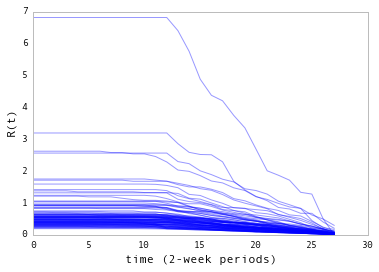

In [80]:
plt.plot(Rt_june['quantiles'][50].T, 'b-', alpha=0.4)
plt.ylabel('R(t)')
plt.xlabel('time (2-week periods)')

In [94]:
model_june.S_age.value.sum(1)

array([52, 54, 54, 44, 60, 61, 54, 56, 72, 61, 51, 67, 59, 55, 63, 48, 51,
       48, 76, 72, 43, 63, 59, 56, 42, 58, 37, 60, 54, 53, 56, 78, 53, 49,
       53, 54, 55, 54, 58, 55, 65, 39, 47, 54, 43, 58, 49, 48, 45, 54, 54,
       58, 55, 65, 59, 51, 57, 49, 55, 59, 53, 47, 65, 55, 43, 46, 53, 53,
       60, 41, 53, 51, 47, 58, 60, 50, 60, 45, 57, 49, 48, 41, 65, 46, 39,
       56, 53, 45, 60, 62, 50, 56, 50])

Could not calculate Gelman-Rubin statistics. Requires multiple chains of equal length.


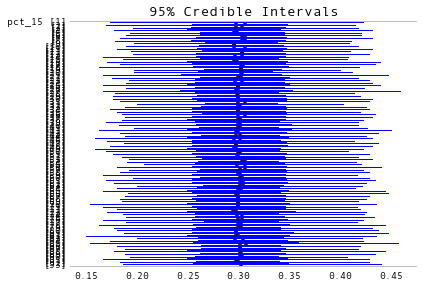

In [96]:
Matplot.summary_plot(model_june.pct_15)

Could not calculate Gelman-Rubin statistics. Requires multiple chains of equal length.


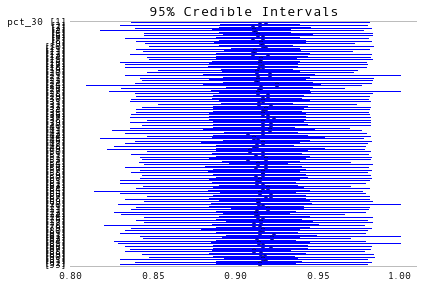

In [86]:
Matplot.summary_plot(model_june.pct_30)

In [81]:
Rt_july = model_july.Rt.stats()

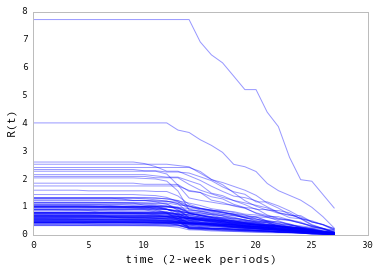

In [82]:
plt.plot(Rt_july['quantiles'][50].T, 'b-', alpha=0.4)
plt.ylabel('R(t)')
plt.xlabel('time (2-week periods)')

Could not calculate Gelman-Rubin statistics. Requires multiple chains of equal length.


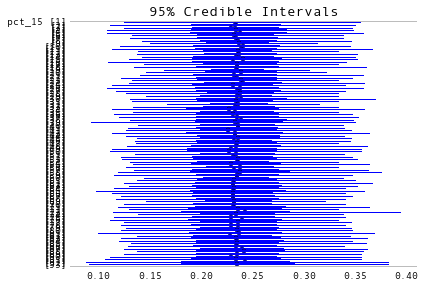

In [88]:
Matplot.summary_plot(model_july.pct_15)

Could not calculate Gelman-Rubin statistics. Requires multiple chains of equal length.


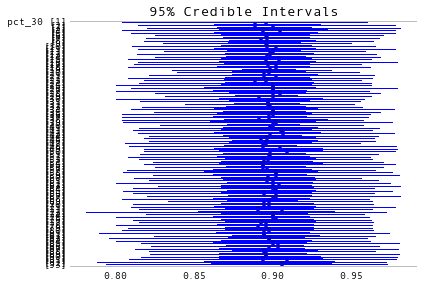

In [95]:
Matplot.summary_plot(model_july.pct_30)

In [83]:
Rt_july_noconf = model_july_noconf.Rt.stats()

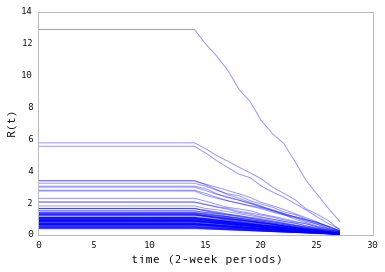

In [84]:
plt.plot(Rt_july_noconf['quantiles'][50].T, 'b-', alpha=0.4)
plt.ylabel('R(t)')
plt.xlabel('time (2-week periods)')

Could not calculate Gelman-Rubin statistics. Requires multiple chains of equal length.


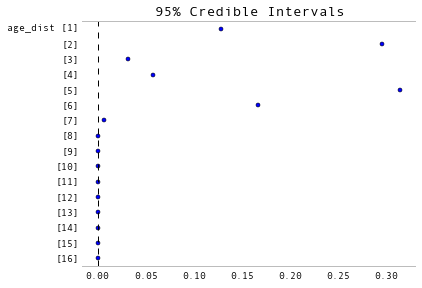

In [68]:
Matplot.summary_plot(model_june.age_dist)

Could not calculate Gelman-Rubin statistics. Requires multiple chains of equal length.


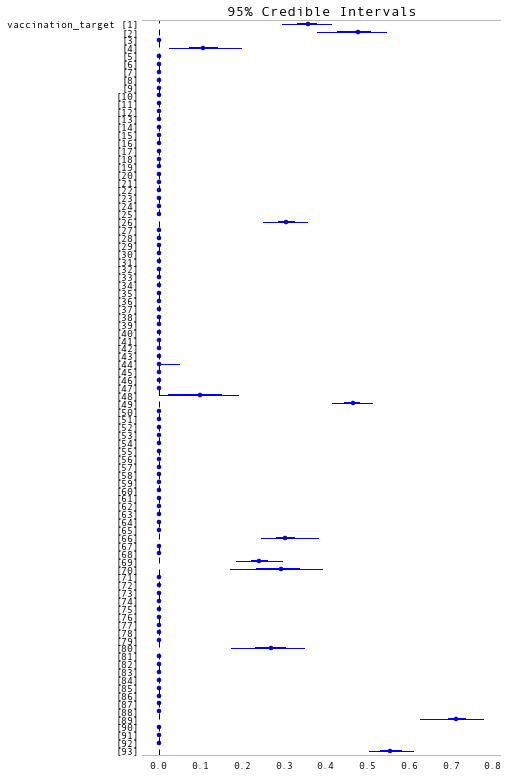

In [44]:
plt.figure(figsize=(8,12))
Matplot.summary_plot(model_july.vaccination_target)

Could not calculate Gelman-Rubin statistics. Requires multiple chains of equal length.


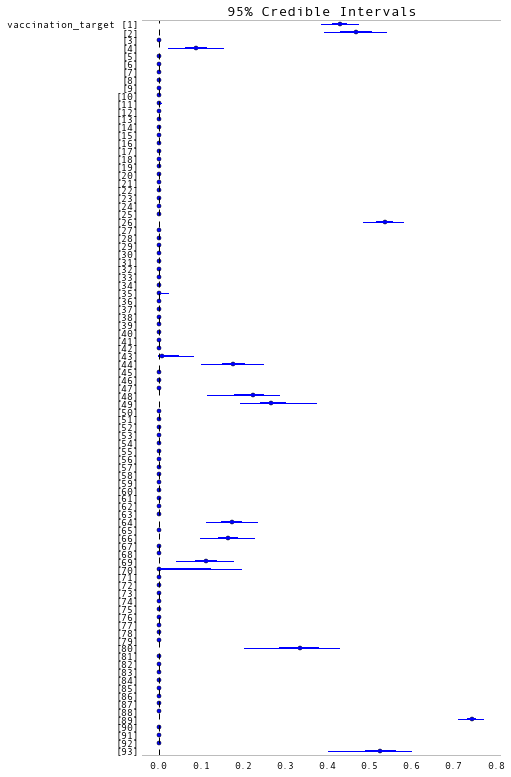

In [46]:
plt.figure(figsize=(8,12))
Matplot.summary_plot(model_july.vaccination_target)

Could not calculate Gelman-Rubin statistics. Requires multiple chains of equal length.


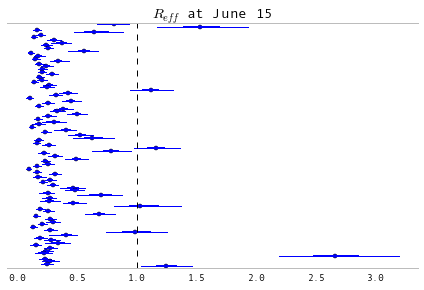

In [56]:
Matplot.summary_plot(model.Rt_obs, vline_pos=1, custom_labels=[''], main=r'$R_{eff}$ at June 15')

This is the estimated distribution of cases at June 15

Could not calculate Gelman-Rubin statistics. Requires multiple chains of equal length.


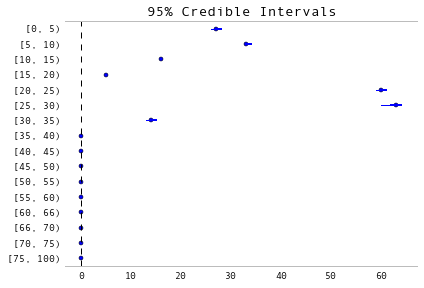

In [57]:
Matplot.summary_plot(model.It, custom_labels=measles_data['AGE_GROUP'].unique())

Plotting alpha


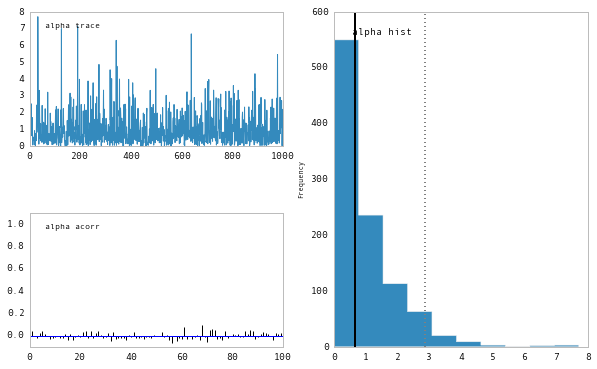

In [69]:
Matplot.plot(model_june.alpha)

## Mapping spatial effects

In [59]:
from mpl_toolkits.basemap import Basemap
import geopandas as gpd

lllat=-24
urlat=-23.3
lllon=-47
urlon=-46.3

SP_base = Basemap(ax=None, lon_0=(urlon + lllon) / 2, lat_0=(urlat + lllat) / 2,
        llcrnrlat=lllat, urcrnrlat=urlat, llcrnrlon=lllon, urcrnrlon=urlon, 
                  resolution='i',
                 epsg='4326')

In [60]:
SP_dist = gpd.GeoDataFrame.from_file('Sao Paulo/Brazil_full/BRA_adm3.shp').to_crs({'proj': 'longlat', 
                                                                               'ellps': 'WGS84', 
                                                                               'datum': 'WGS84'})

KeyboardInterrupt: 

In [ ]:
SP_dist['DIST_NAME'] = [trans.trans(_).upper() for _ in SP_dist.NAME_3]

In [ ]:
SP_dist.head()

In [ ]:
SP_dist.NAME_3.unique()

In [ ]:
district_names

In [ ]:
from matplotlib.pyplot import cm

map_fig = plt.figure(figsize=(16,12))
map_ax = plt.gca()
SP_base.drawcoastlines()
SP_base.drawrivers()

SP_dist.plot(column='Shape_Leng', colormap=cm.Blues, axes=map_ax)